In [1]:
import os 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

### Introduction 

Dans ce notebook, vous pouvez retrouver l'étude complète qui nous a permis à partir des données preprocessées de choisir un modèle, le tester et mesurer ses performances. 
Ainsi, l'étude se déroule en XX étapes: 
1) La lecture des données préparées & train-test split
2) Feature scaling
3) Comparaison des modèles
4) Optimisation des paramètres - CV
5) Evaluation finale sur le test set. 

### 1. Lecture des données préparées 

Pour commencer, nous récupérons les fichiers préparés qui sont dans le folder "../data/prepared_final". Ce dossier contient les données préparées pour les données d'entraînements et les données que nous devrons soumettre plus tard. Par la même coccasion, nous récupérons les labels que nous utiliserons plus tard.

In [2]:
# folder containing prepared_data
folder_name = "prepared_final"

# list prepared files
cwd = os.getcwd()
data_dir = os.path.join(cwd, '..', 'data')
prepared_data_dir = os.path.join(data_dir, folder_name)
files = os.listdir(prepared_data_dir)

# separate training files from submission files
submission_files = [file for file in files if 'test' in file]
train_files = list(set(files) - set(submission_files))

# get labels
label_file = os.path.join(data_dir, 'targets_train.csv')


Ensuite, nous isolons directement un test set (pour un test final). Plus tôt cela est fait, plus les chances d'introduire un biais et faible. Notre test set sera utilisé comme des données que nous n'aurions jamais vu à la fin.
Précisément, ici nous gardons 2 fichiers comme données tests finals.

In [3]:
# train-test split
trainfiles = train_files[:-2]
testfiles = train_files[-2:]

print("train files: ", trainfiles)
print("test files: ", testfiles)

train files:  ['prepared_4.csv', 'prepared_3.csv', 'prepared_2.csv', 'prepared_5.csv', 'prepared_1.csv']
test files:  ['prepared_0.csv', 'prepared_6.csv']


Nous allons maintenant convertir tout ceci en un dataframe et ajouter les labels.

In [4]:
# list of train and test dataframes
train_dataframes = []
test_dataframes = []

# create train dataframes corresponding to each file
for file in trainfiles:
    file_path = os.path.join(prepared_data_dir, file)
    train_dataframes.append(pd.read_csv(file_path, index_col="identifier"))

# create test dataframes corresponding to each file
for file in testfiles:
    file_path = os.path.join(prepared_data_dir, file)
    test_dataframes.append(pd.read_csv(file_path, index_col="identifier"))

# now group dataframes together
df_train = pd.concat(train_dataframes, ignore_index=False)
df_test = pd.concat(test_dataframes, ignore_index=False)

# finally, add labels
target = pd.read_csv(label_file, index_col='identifier')
df_train = df_train.join(target['target'], how='left')
df_test = df_test.join(target['target'], how='left')

In [5]:
# drop useless columns and print out first rows just in case
df_train.drop('0', axis=1, inplace=True)
df_train.dropna(inplace=True)
print("Train dataframe: ")
df_train.head()

Train dataframe: 


,SEF90_First_EEG,SEF95_First_EEG,SEF50_First_EEG,SP_First_EEG,SM1_First_EEG,SM2_First_EEG,SM3_First_EEG,SM4_First_EEG,Spectrale_entropy_First_EEG,Delta_absolute_First_EEG,...,Band_ratio_1_Z_axis,Band_ratio_2_Z_axis,Band_ratio_3_Z_axis,Band_ratio_4_Z_axis,Hjort_activity_Z_axis,Hjort_mobility_Z_axis,Hjort_complexity_Z_axis,75Percentile_Z_axis,Zero_crossing_rate_Z_axis,target
identifier,,,,,,,,,,,,,,,,,,,,,
10000.0,3.100000,5.800000,1.166667,0.0,1.695175e+09,2.638510e+20,6.809406e+31,2.091899e+43,6.262214,1.360318e+11,...,230.828713,4.152119e-03,0.0,0.958428,0.057418,0.024455,1.362229,0.067440,0.057544,0.0
10001.0,4.300000,5.533333,1.433333,0.0,4.318862e+05,1.187559e+13,5.215906e+20,2.771896e+28,6.612633,4.054678e+07,...,976.473575,9.853351e-04,0.0,0.962154,0.020269,0.031833,1.352479,0.078533,0.020283,0.0
10002.0,4.966667,5.933333,2.233333,0.0,8.534241e+04,3.107811e+11,1.675904e+18,1.059260e+25,7.031513,8.109419e+06,...,1232.253627,7.709552e-04,0.0,0.950012,0.012949,0.033339,1.188277,0.057350,0.012978,0.0
10003.0,3.566667,4.600000,1.866667,0.0,2.230754e+06,2.059409e+14,2.395959e+22,3.056785e+30,6.934269,2.573352e+08,...,466947.123980,1.715853e-07,0.0,0.080121,0.001249,0.037619,1.108619,0.009236,0.001253,0.0
10004.0,2.300000,5.000000,0.733333,0.0,1.558588e+06,1.702691e+14,2.495270e+22,4.050082e+30,6.395352,1.091540e+08,...,1653.019877,5.566716e-04,0.0,0.920189,0.027072,0.024418,1.371279,0.036518,0.027271,0.0


In [6]:
# drop useless columns and print out first rows just in case
df_test.drop('0', axis=1, inplace=True)
df_test.dropna(inplace=True)
print("Test dataframe: ")
df_test.head()

Test dataframe: 


,SEF90_First_EEG,SEF95_First_EEG,SEF50_First_EEG,SP_First_EEG,SM1_First_EEG,SM2_First_EEG,SM3_First_EEG,SM4_First_EEG,Spectrale_entropy_First_EEG,Delta_absolute_First_EEG,...,Band_ratio_1_Z_axis,Band_ratio_2_Z_axis,Band_ratio_3_Z_axis,Band_ratio_4_Z_axis,Hjort_activity_Z_axis,Hjort_mobility_Z_axis,Hjort_complexity_Z_axis,75Percentile_Z_axis,Zero_crossing_rate_Z_axis,target
identifier,,,,,,,,,,,,,,,,,,,,,
0.0,2.666667,3.966667,0.866667,0.0,79.252459,9.620885e+05,2.326732e+10,7.406450e+14,5.725599,7347.728572,...,512.504737,0.001870,0.0,0.958244,0.000027,0.026729,1.457473,0.001986,0.000027,0.0
1.0,2.666667,4.400000,1.033333,0.0,55.468202,3.361163e+05,3.454033e+09,4.609771e+13,5.978044,4393.904638,...,567.881376,0.001694,0.0,0.961853,0.000914,0.026704,1.231548,0.007786,0.000915,0.0
2.0,2.700000,3.633333,1.266667,0.0,49.575288,1.835872e+05,1.021911e+09,6.874962e+12,6.285140,5328.923252,...,38.498872,0.025009,0.0,0.962830,0.000071,0.014332,0.882372,0.001908,0.000070,0.0
3.0,3.700000,7.466667,1.066667,0.0,63.346565,4.038258e+05,4.262463e+09,5.205751e+13,6.257641,5961.235831,...,105.479402,0.009120,0.0,0.961988,0.007120,0.023254,1.442748,0.051401,0.007127,0.0
4.0,1.833333,2.466667,0.866667,0.0,1522.437769,3.543400e+08,1.319126e+14,5.887484e+19,5.384868,172526.924372,...,7543.834538,0.000121,0.0,0.911327,0.002705,0.024730,1.251337,0.022282,0.002709,0.0


Enfin, nous allons séparer les features des labels pour pouvoir créer nos premiers modèles.

In [7]:
# train data 
y_train = df_train.target
X_train = df_train.drop('target', axis=1)

# train data 
y_test = df_test.target
X_test = df_test.drop('target', axis=1)

Avant de passer à la partie suivante, nous vouloons juste observer quelle est la proportion de chaque métrique dans notre jeu de données. En effet, cela peut justifier l'optimisation de notre par rapport à une métrique plutôt qu'une aute et sera donc utile dans la suite (notamment dans l'interprétation des résultats).

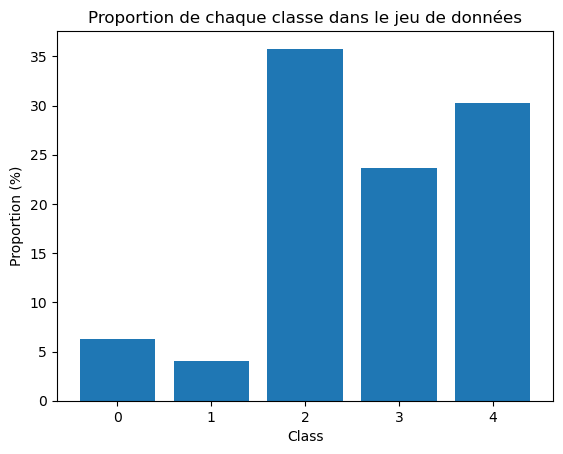

In [8]:
plt.bar(df_train.target.value_counts().index, df_train.target.value_counts().values * 100 / df_train.shape[0])
plt.title("Proportion de chaque classe dans le jeu de données")
plt.xlabel("Class")
plt.ylabel("Proportion (%)")
plt.show()

Ainsi, on peut voir que la classe 1 ne représente que 5% des labels tandis que la classe 2 presque 35% ! Cette grande différence justifie le choix de la métrique F1-score pour le challenge ! 

### 2. Feature scaling 

Dans cette partie, nous allons scale nos data. En effet, avoir des données normalisées permet à la plupart des algorithmes de mieux fonctionner puisque les features sont toutes sur la même amplitude. 

In [9]:
# define scaler
scaler = StandardScaler(with_std=True)

# scale train and test sets
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

### 3. Comparaison des modèles 

Dans cette partie, les données sont prêtes à être données comme input des modèles. Ainsi, la première chose à faire est de définir les modèles que nous souhaitons utiliser dans notre étude. 

In [10]:
# SVM
svm_model = SVC(
    kernel='rbf', 
    C=1, 
    decision_function_shape='ovr',  # 'ovr' stands for One-vs-Rest
    random_state=42
)  

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# gradient boosting
xgboost_model = xgb.XGBClassifier(
    objective='multi:softmax',  # For multiclass classification
    num_class=len(set(y_train)),  # Number of classes
    random_state=42
)

Ensuite, nous allons tester pour chaque modèle les performances de celui-ci pour avoir une idée du meilleur algorithme pour notre problème. 

### 4. Optimisation des paramètres

### 5. Evaluation finale 